# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

In [1]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"


In [3]:
# !pip list
# !pip install -q seaborn

In [4]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

np.set_printoptions(precision=3, suppress=True)

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 

    Voltage_measured: Fuel Cell terminal voltage (Volts)
    Current_measured: Fuel Cell output current (Amps)
    Temperature_measured: Fuel Cell temperature (degree C)
    Current_load: Current measured at load (Amps)
    Voltage_load: Voltage measured at load (Volts)
    Time: Time vector for the cycle (seconds)
    Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V
    Datetime: the date and time of the start of the cycle
    Ambient_temperature: Temperature in which the fuel cell is stored (degree C)
    Cycle: Charge cycle of the fuel cell


In [5]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [6]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [7]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [8]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [9]:
print(f"The number of unique vlaues for ambient_temperature is: {df['ambient_temperature'].nunique()} ")

print(f"The Maximum value for voltage_measured is: {df['voltage_measured'].max()} ")

The number of unique vlaues for ambient_temperature is: 1 
The Maximum value for voltage_measured is: 8.393141180564633 


This shows that there is a consistency of ambient temperature in this dataset. This will be a limitation in the final model. We also need to check whether this voltage (which seems high)  is an outlier or not

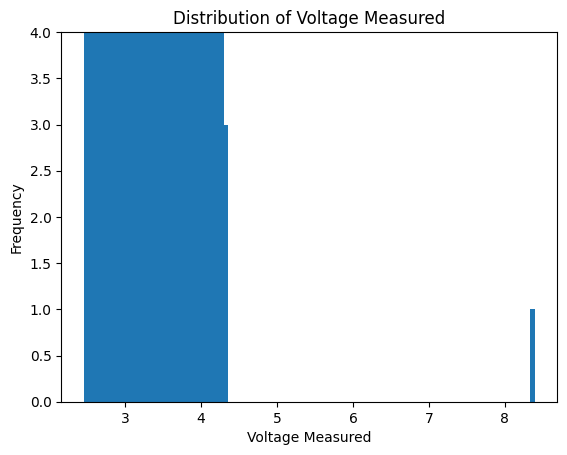

In [10]:
plt.hist(df['voltage_measured'], bins = 100)
plt.xlabel('Voltage Measured')
plt.ylabel('Frequency')
plt.title('Distribution of Voltage Measured')
plt.ylim(0,4)
plt.show()

As shown above, there is only a singular value above 4.xxxx, making the maximum vlaue shown above a clear outlier. We need to remove this value and so shall remove it.

In [11]:
value = df['voltage_measured'].max()
df = df[df['voltage_measured'] != value]

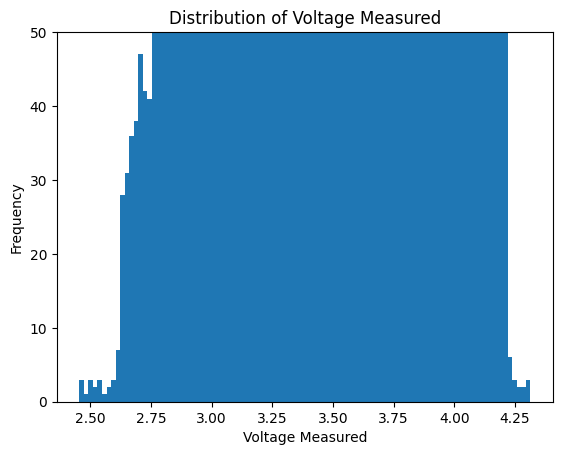

In [12]:
plt.hist(df['voltage_measured'], bins = 100)
plt.xlabel('Voltage Measured')
plt.ylabel('Frequency')
plt.title('Distribution of Voltage Measured')
plt.ylim(0,50)
plt.show()

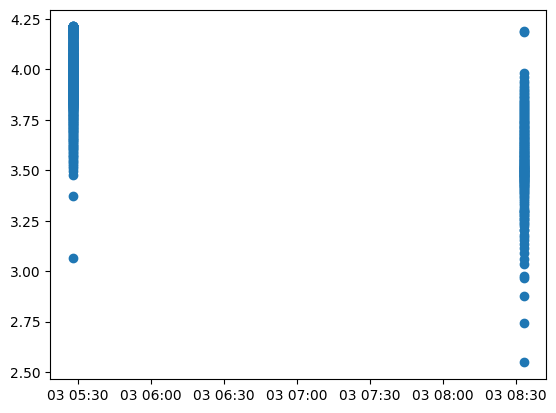

In [13]:
cycle = 5
plt.scatter(df[df['cycle'] == cycle]['datetime'], df[df['cycle'] == cycle]['voltage_measured'])

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['SOC'] = ((df['voltage_measured'] - 2.7)/(df['voltage_measured'].max() - 2.7))

df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity,SOC
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487,0.726910
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487,0.933546
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487,0.933602
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487,0.932955
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487,0.932824


# Machine Learning (RBFN)

Now we begin to build our Radial Bias Function Network

https://www.kaggle.com/code/residentmario/radial-basis-networks-and-custom-keras-layers

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, RepeatVector, TimeDistributed, Layer
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from keras import backend as K
from keras.losses import binary_crossentropy
import warnings

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
prep_df = df.drop(['datetime', 'ambient_temperature', 'capacity'], axis = 1)
train_dataset = prep_df.sample(frac=0.8, random_state = 0)
test_dataset = prep_df.drop(train_dataset.index)

In [19]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,470278.0,95.409326,42.773550,1.000000,60.000000,96.000000,132.000000,168.000000
voltage_measured,470278.0,4.103417,0.213920,2.471315,4.087951,4.205138,4.205908,4.313703
current_measured,470278.0,0.368397,0.909215,-4.479660,0.039570,0.171744,1.262769,1.530376
temperature_measured,470278.0,26.375034,2.778459,23.214802,24.489700,25.483258,27.353311,41.436500
current,470278.0,0.635259,0.737868,-4.468000,0.057000,0.261000,1.498000,1.998400
voltage,470278.0,4.021590,1.212991,0.000000,4.240000,4.305000,4.656000,5.002000
time,470278.0,4764.131279,3149.310763,0.000000,1925.250000,4465.765000,7505.461250,10807.328000
SOC,470278.0,0.869687,0.132564,-0.141715,0.860103,0.932723,0.933200,1.000000


In [20]:
# These are the features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features.iloc[0])
# These contain the target variables
train_labels = train_features.pop('SOC')
test_labels = test_features.pop('SOC')
print('--------------------------')
print(train_features.iloc[0])

cycle                   144.000000
voltage_measured          4.072904
current_measured          1.511057
temperature_measured     26.967343
current                   1.498000
voltage                   4.818000
time                    955.328000
SOC                       0.850779
Name: 489564, dtype: float64
--------------------------
cycle                   144.000000
voltage_measured          4.072904
current_measured          1.511057
temperature_measured     26.967343
current                   1.498000
voltage                   4.818000
time                    955.328000
Name: 489564, dtype: float64


## Normalisation

Here we will normalise the values to give equal weight to each feature

In [21]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cycle,95.409326,42.773550
voltage_measured,4.103417,0.213920
current_measured,0.368397,0.909215
temperature_measured,26.375034,2.778459
current,0.635259,0.737868
voltage,4.021590,1.212991
time,4764.131279,3149.310763
SOC,0.869687,0.132564


In [22]:
train_dataset.head()

,cycle,voltage_measured,current_measured,temperature_measured,current,voltage,time,SOC
489564,144,4.072904,1.511057,26.967343,1.498,4.818,955.328,0.850779
383689,118,4.201838,0.001151,24.421995,0.000,0.003,10279.687,0.930678
580550,167,4.205604,0.081628,24.197675,0.080,4.261,6816.406,0.933011
110451,51,4.207118,0.031110,25.934996,0.031,4.240,9218.344,0.933950
354821,111,4.206939,1.083693,30.320120,1.074,4.748,2429.187,0.933839


## Regression with RBFN

### Preparing the Data

In [23]:
print(train_features.shape)
print(train_features.iloc[0].shape)
print(train_features.iloc[0].squeeze())

(470278, 7)
(7,)
cycle                   144.000000
voltage_measured          4.072904
current_measured          1.511057
temperature_measured     26.967343
current                   1.498000
voltage                   4.818000
time                    955.328000
Name: 489564, dtype: float64


In [24]:
sample_size = train_features.shape[0] # number of samples in train set
time_steps  = train_features.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_features_reshaped = train_features.values.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_features_reshaped.shape)
print("1 Sample shape:\n",train_features_reshaped[0].shape)
print("An example sample:\n", train_features_reshaped[0])

After reshape train data set shape:
 (470278, 7, 1)
1 Sample shape:
 (7, 1)
An example sample:
 [[144.   ]
 [  4.073]
 [  1.511]
 [ 26.967]
 [  1.498]
 [  4.818]
 [955.328]]


In [25]:
test_features_reshaped = test_features.values.reshape(test_features.shape[0],test_features.shape[1],1)
n_timesteps = train_features_reshaped.shape[1] #7
n_features  = train_features_reshaped.shape[2] #1

In [26]:
normalizer = keras.layers.Normalization(axis = 1)
normalizer.adapt(np.array(train_features_reshaped))

In [27]:
train_features_reshaped = normalizer(train_features_reshaped)
test_features_reshaped = normalizer(test_features_reshaped)

## Defining the model

In [42]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
    def get_config(self):
        config = super(RBFLayer, self).get_config()
        config.update({
            'units': self.units,
            'gamma': self.gamma,
        })
        return config

In [57]:
def build_and_compile_model(): 
    
    model = Sequential()
    model.add(Flatten(input_shape=(n_timesteps,n_features)))
    model.add(RBFLayer(128, 1))
    model.add(Dense(1, name='foo'))
    model.compile(loss= 'mean_squared_error',
                 optimizer = 'rmsprop', 
                 metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SOC]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [58]:
rbfn_model = build_and_compile_model()
rbfn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 7)                 0         
                                                                 
 rbf_layer_2 (RBFLayer)      (None, 128)               896       
                                                                 
 foo (Dense)                 (None, 1)                 129       
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [59]:
epochs = 10
checkpoint_filepath = os.path.join('checkpoints', 'RBFN_SOC{epoch:02d}-{val_loss:.4f}.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

In [60]:
%%time
history.append(rbfn_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

Epoch 1/10
11757/11757 [==============================] - 134s 11ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1168 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0875
Epoch 2/10
11757/11757 [==============================] - 128s 11ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0899 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0918
Epoch 3/10
11757/11757 [==============================] - 127s 11ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0899 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0898
Epoch 4/10
11757/11757 [==============================] - 131s 11ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0899 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0866
Epoch 5/10
11757/11757 [==============================] - 117s 10ms/

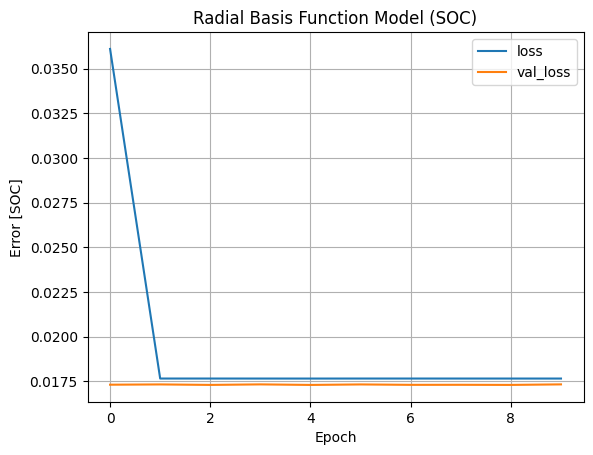

In [61]:
plot_loss(history[-1], 'Radial Basis Function Model (SOC)')

In [62]:
model_path = os.path.join("models","RBFN_SOC_02.keras")

In [63]:
rbfn_model.save(model_path)

### Performance

In [64]:
rbfn_model = tf.keras.models.load_model(model_path, custom_objects={'RBFLayer': RBFLayer})

In [65]:
test_predictions = rbfn_model.predict(test_features).flatten()

3675/3675 [==============================] - 7s 2ms/step


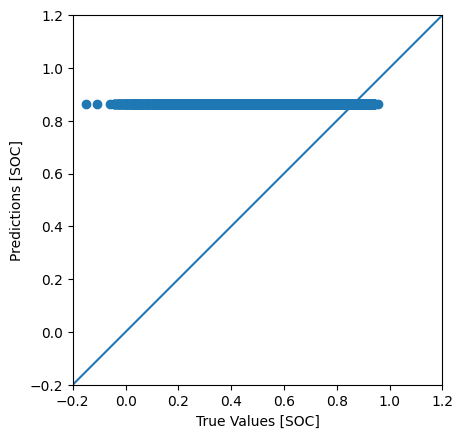

In [66]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
lims = [-0.2, 1.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

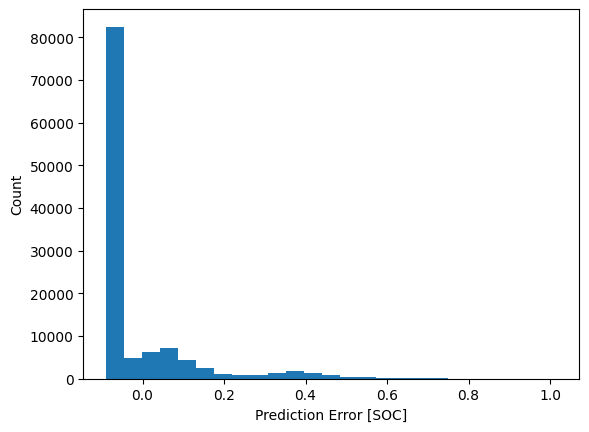

In [67]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SOC]')
_ = plt.ylabel('Count')

In [68]:
# Calculate metrics
mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 0.017478735660422438
RMSE: 0.1322071694743611
MAE: 0.09211702799026579
R2 Score: -0.0015530627202471337
